# Evaluación de clasificadores

## Métricas para clasificadores binarios

El regresor logístico retorna una predicción probabilística en el rango $[0, 1]$. Podemos convertir esta predicción en una decisión binaria seleccionando un umbral $\mathcal{T}$ tal que

$$
d_i = 
\begin{cases} 
0, & \text{si } f_\theta(\vec x_i)  < \mathcal{T} \\ 
1, & \text{si } f_\theta(\vec x_i) \geq \mathcal{T}
\end{cases}
$$

:::{note}

En un clasificador binario usar $\mathcal{T}=0.5$ es equivalente al tomar el argumento máximo de la predicción probabilística.

:::



Una vez seleccionado el umbral se puede contar la cantidad de 

- **True positives** (TP): Ejemplos de clase (1) y clasificados como (1)
- **True negative** (TN): Ejemplos de clase (0) y clasificados como (0)
- **False positives** (FP): Ejemplos de clase (0) y clasificados como (1): **Error tipo I**
- **False negative** (FN): Ejemplos de clase (1) y clasificados como (0): **Error tipo II**

A partir de estas métricas se construye la **tabla o matriz de confusión** del clasificador

|Predicho como/Etiqueta|Positivo|Negativo|
|---|---|---|
|Positivo:|TP | FP |
|Negativo:| FN | TN |

Se puede estimar una matriz de confusión con *scikit learn* con 

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


np.random.seed(20)
X, y = make_classification(n_features=2, n_classes=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1)


model = LogisticRegression(penalty=None)
model.fit(X, y)

for T in [0.1, 0.25, 0.5, 0.75, 0.9]:
    display(T, confusion_matrix(y_true=y, y_pred=model.predict_proba(X)[:, 1] > T))
    

0.1

array([[37, 13],
       [ 2, 48]])

0.25

array([[46,  4],
       [ 3, 47]])

0.5

array([[48,  2],
       [ 3, 47]])

0.75

array([[49,  1],
       [ 6, 44]])

0.9

array([[50,  0],
       [ 7, 43]])

:::{warning}

Utilizar $\mathcal{T}=0.5$ asume que el costo o riesgo de cometer un error tipo 1 es equivalente al de cometer un error tipo 2.

:::

:::{note}

Modificando el umbral podemos ajustar el compromiso (*trade-off*) entre el error tipo 1 y el error tipo 2.

:::

La matriz de confusión suele resumirse con las siguientes métricas:

*True Positive Rate* o *Recall*
: La proporción de positivos correctamente clasificados respecto al total de positivos

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

*False Positive Rate* 
: La proporción de negativos incorrectamente clasificados respecto al total de negativos

$$
\text{FPR} = \frac{FP}{TN + FP} = 1 - \frac{TN}{TN + FP}
$$

*Precision* o Pureza
: La proporción de positivos correctamente clasificados respecto a todos los ejemplos clasificados como positivo

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

*Accuracy*
: La proporción de ejemplos correctamente clasificados

$$
\text{Accuracy} = \frac{TP+TN}{TP + FP + FN+ TN}
$$

*F1-score*
: La media armónica entre Recall y Precision asumiendo igual ponderación

$$
\text{f1-score} = \frac{2 \cdot \text{Recall} \cdot \text{Precision}}{\text{Recall} + \text{Precision}}
$$

:::{tip}

Si las clases son desbalanceadas entonces *f1-score* es preferible ante *accuracy*

:::

Podemos obtener estas métricas con *scikit-learn* utilizando

In [2]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(y_true=y, y_pred=model.predict_proba(X)[:, 1] > T)

0.93

In [3]:
print(classification_report(y_true=y, y_pred=model.predict_proba(X)[:, 1] > T))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        50
           1       1.00      0.86      0.92        50

    accuracy                           0.93       100
   macro avg       0.94      0.93      0.93       100
weighted avg       0.94      0.93      0.93       100



## Curvas de desempeño

Podemos estudiar gráficamente como cambian estas métricas en función del umbral utilizando una curva de desempeño. Típicamente se usan

- Curva ROC: TPR vs FPR
- Curva Precision vs Recall

En scikit-learn se pueden calcular con

In [4]:
from sklearn.metrics import roc_curve

fpr, tpr, th = roc_curve(y_true=y, y_score=model.predict_proba(X)[:, 1])

Que retorna un arreglo con las tasas de falsos positivos, verdaderos positivos y los umbrales (escogidos automáticamente) que se utilizaron para calcularlas.

Graficamos la curva ROC como:

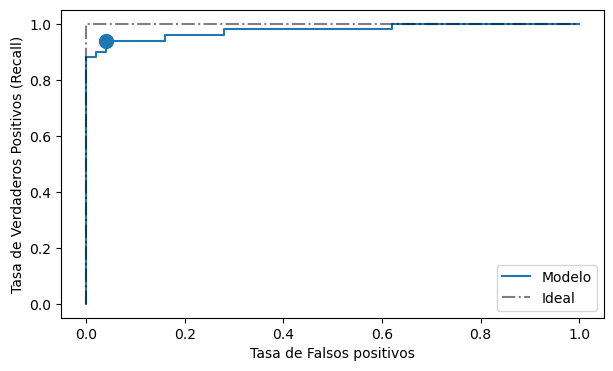

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(fpr, tpr, label='Modelo')
ax.plot([0, 0, 1], [0, 1, 1], 'k-.', alpha=0.5, label='Ideal')
ax.legend()
idx = np.argmin((th - 0.5)**2)
ax.scatter(fpr[idx], tpr[idx], s=100)
ax.set_xlabel('Tasa de Falsos positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos (Recall)');

La curva ROC nos muestra el desempeño del modelo medido en función del umbral. Inspeccionado la curva ROC podemos seleccionar un punto de operación (umbral) que sea apropiado para nuestro problema

:::{note}

En general tendremos que se puede dismininuir el error tipo II (aumentar TPR) a costa de aumentar el error tipo I (aumentar FPR)

:::

A continuación se calcula y muestra la curva de precision-recall, la cual es más apropiada que la anterior en el caso de clases desbalanceadas

In [6]:
from sklearn.metrics import precision_recall_curve

prec, rec, th = precision_recall_curve(y_true=y, probas_pred=model.predict_proba(X)[:, 1])

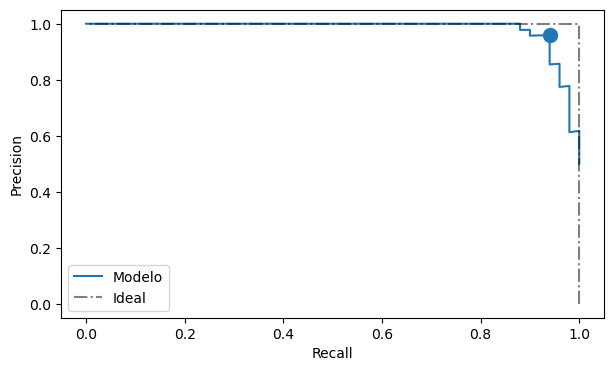

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(rec, prec, '-', label='Modelo');
ax.plot([1, 1, 0], [0, 1, 1], 'k-.', alpha=0.5, label='Ideal')
ax.legend()
idx = np.argmin((th - 0.5)**2)
ax.scatter(rec[idx], prec[idx], s=100)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');